In [2]:
from retrival import *

In [3]:
query_source = QuerySource()
indexer = RedisIndexer(index_name="doc_vec", url=config.REDIS_URL)
await indexer.init_redis()

model = ColBERTModel()

## preprocessing
aggregator = []
for query in query_source.read():
    embedding = model.compute_query_representation(query)        
    results = await indexer.search(embedding, 100)
    aggregator.extend(results)
# print(aggregator)
 
    

using device: cuda:0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
## search
uniq_doc_ids=[]
for result in aggregator:
    # print(result)
    for doc in result.docs:
        uniq_doc_ids.append(doc.doc_id)
uniq_doc_ids = list(set(uniq_doc_ids))
print("uniq_doc_ids:", uniq_doc_ids)
print("uniq_doc_ids len:", len(uniq_doc_ids))

uniq_doc_ids: ['53', '388', '179', '1101', '877', '1040', '950', '355', '61', '90', '18', '1011', '14', '1051', '275', '266', '1078', '373', '734', '319', '656', '7', '546', '1000', '326', '1007', '931', '993', '843', '1057', '698', '745', '209', '245', '530', '1059', '294', '93', '222', '1034', '593', '792', '692', '50', '1079', '458', '1077', '75', '646', '652', '254', '1008', '161', '489', '300', '72', '455', '504', '418', '592', '191', '651', '205', '52', '497', '589', '703', '783', '516', '693', '336', '1082', '976', '1028', '1050', '649', '708', '933', '1014', '1045', '968', '627', '413', '733', '624', '981', '4', '966', '24', '500', '1102', '855', '735', '302', '387', '1085', '29', '1103', '47', '401', '241', '524', '157', '818', '1023', '878', '1', '883', '34', '1035', '180', '926', '412', '281', '316', '590', '892', '1096', '928', '146', '591', '868', '23', '1122', '480', '84', '153', '786', '1120', '107', '268', '55', '906', '684', '1060', '133', '680', '900', '74', '1043', '

In [5]:
## Retrival
uniq_docs = []
for doc_id in uniq_doc_ids[:10]:
    key = f'paper:{doc_id}'
    doc = await indexer.fetch_one(key, field="doc")
    uniq_docs.append({
        "doc_id": doc_id,
        "doc": doc
    })
print("uniq_docs len : ", len(uniq_docs))

key: paper:53
key: paper:388
key: paper:179
key: paper:1101
key: paper:877
key: paper:1040
key: paper:950
key: paper:355
key: paper:61
key: paper:90
uniq_docs len :  10


In [6]:
from tqdm import tqdm

In [7]:
async def gather_with_concurrency(redis_conn, *doc_ids, field=None):
    semaphore = asyncio.Semaphore(50)
    async def fetch_doc(doc_id):       
        # print(len(data_elem))
        fetched = None
        async with semaphore:            
            # save vector data
            key = f'paper:{doc_id}'
            if field:
                fetched = await redis_conn.hget(key, field)
            else:
                fetched = await redis_conn.hgetall(key)
        return fetched
    # gather with concurrency
    return await asyncio.gather(*[fetch_doc(doc_id) for doc_id in tqdm(doc_ids)])
    # load_elems(data_elems[0])

In [8]:
agg_docs = await gather_with_concurrency(indexer.redis_conn, *uniq_doc_ids, field='doc')

100%|██████████| 443/443 [00:00<00:00, 1070320.66it/s]


In [9]:
# agg_docs

In [10]:
# data = str(uniq_docs[0]['doc'])
# model.tokenizer(data, return_tensors="pt").to(model.device)

In [11]:
# model.compute_score(query,uniq_docs[0]['doc'])

In [12]:

## Ranking
# print(list(uniq_docs.values())[0]["doc"])
late_interaction_ranking = []
for each in uniq_docs[:3]:    
    doc = str(each["doc"])
    score = model.compute_score(query, doc)
    each["late_interaction_score"] = score
    late_interaction_ranking.append(each)
#         reranker.write(score, doc)
late_interaction_ranking.sort(
    key=lambda x: x["late_interaction_score"]
)

In [13]:

## render
print(late_interaction_ranking)
print([
    (each["doc_id"], each["late_interaction_score"] , each["doc"])
    for each in late_interaction_ranking
])    



[{'doc_id': '179', 'doc': b' estimation of rate control parameters for video coding using c n n rate control is essential to ensure efficient video delivery typical rate control algorithms rely on bit allocation strategies to appropriately distribute bits among frames as reference frames are essential for exploiting temporal redundancies intra frames are usually assigned a larger portion of the available bits in this paper an accurate method to estimate number of bits and quality of intra frames is proposed which can be used for bit allocation in a rate control scheme the algorithm is based on deep learning where networks are trained using the original frames as inputs while distortions and sizes of compressed frames after encoding are used as ground truths two approaches are proposed where either local or global distortions are predicted ', 'late_interaction_score': 67.1043701171875}, {'doc_id': '53', 'doc': b' an empirical evaluation of similarity measures for time series classificat

['[CLS]', 'b', "'", 'estimation', 'of', 'rate', 'control', 'parameters', 'for', 'video', 'coding', 'using', 'c', 'n', 'n', 'rate', 'control', 'is', 'essential', 'to', 'ensure', 'efficient', 'video', 'delivery', 'typical', 'rate', 'control', 'algorithms', 'rely', 'on', 'bit', 'allocation', 'strategies', 'to', 'appropriately', 'distribute', 'bits', 'among', 'frames', 'as', 'reference', 'frames', 'are', 'essential', 'for', 'exploit', '##ing', 'temporal', 'red', '##unda', '##ncies', 'intra', 'frames', 'are', 'usually', 'assigned', 'a', 'larger', 'portion', 'of', 'the', 'available', 'bits', 'in', 'this', 'paper', 'an', 'accurate', 'method', 'to', 'estimate', 'number', 'of', 'bits', 'and', 'quality', 'of', 'intra', 'frames', 'is', 'proposed', 'which', 'can', 'be', 'used', 'for', 'bit', 'allocation', 'in', 'a', 'rate', 'control', 'scheme', 'the', 'algorithm', 'is', 'based', 'on', 'deep', 'learning', 'where', 'networks', 'are', 'trained', 'using', 'the', 'original', 'frames', 'as', 'inputs', '

/home/jovyan/arxiv-search/vecsim/retrival.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


['[CLS]', 'b', "'", 'an', 'empirical', 'evaluation', 'of', 'similarity', 'measures', 'for', 'time', 'series', 'classification', 'time', 'series', 'are', 'ubiquitous', 'and', 'a', 'measure', 'to', 'assess', 'their', 'similarity', 'is', 'a', 'core', 'part', 'of', 'many', 'computational', 'systems', 'in', 'particular', 'the', 'similarity', 'measure', 'is', 'the', 'most', 'essential', 'ingredient', 'of', 'time', 'series', 'cluster', '##ing', 'and', 'classification', 'systems', 'because', 'of', 'this', 'importance', 'countless', 'approaches', 'to', 'estimate', 'time', 'series', 'similarity', 'have', 'been', 'proposed', 'however', 'there', 'is', 'a', 'lack', 'of', 'comparative', 'studies', 'using', 'empirical', 'rigorous', 'quantitative', 'and', 'large', 'scale', 'assessment', 'strategies', 'in', 'this', 'article', 'we', 'provide', 'an', 'extensive', 'evaluation', 'of', 'similarity', 'measures', 'for', 'time', 'series', 'classification', 'following', 'the', 'aforementioned', 'principles', 'w

<Figure size 10080x792 with 0 Axes>

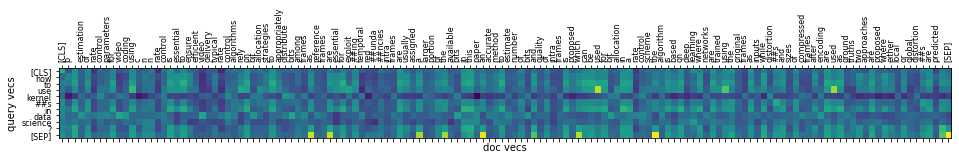

<Figure size 16632x792 with 0 Axes>

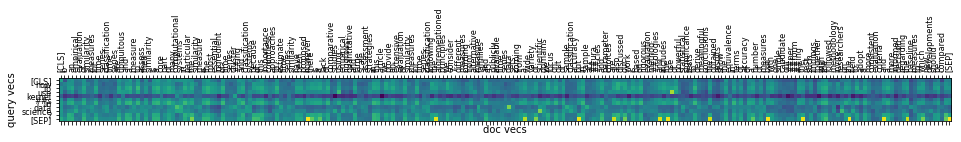

<Figure size 15408x792 with 0 Axes>

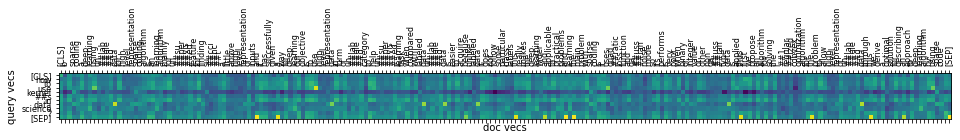

In [14]:
## explainability
for each in late_interaction_ranking:
    score_map, doc_tokens, query_tokens = model.compute_interaction_map(
        query, str(each["doc"])
    )
    print(score_map.shape)
    interaction_map = get_interaction_image(score_map, doc_tokens, query_tokens)
    each["interaction_map"]=interaction_map
print(len(late_interaction_ranking))
# print(late_interaction_ranking[0]["interaction_map"])
